<h1 align="center"> Crabi Test</h1>

<p align="center">
  <img src="/Users/geyne/Desktop/CrabiTest/Images/unnamed.png" alt="Crabi Logo" width="120">
</p>

# Diccionario
1. Reservas: Fondos para cubrir los siniestros 
2. Siniestralidad : Mide que tanto se esta pagando en siniestros en relacion a lo que se cobra en primas, a mayor siniestralidad menor profit 
3. Servicios: Son las asistencias proporcionadas a los asegurados
4. Severidad: Lo que tiene que pagar la aseguradora por un siniestro
5. Deducible: es un porcentaje del valor comercial del auto, Aplica solo a: **Danos Materiales y robo total**

# Data MarkDowns
A nivel de datos Crabi utiliza la tabla **CLAIM** para llevar el historico de cada siniestro, y **Service** las acciones de cada siniestro

- `claim.xlsx` – Historico de siniestros
- `service.xlsx` – Servicios aplicados a los siniestros de la tabla service 
- `people.xlsx` – informacion del asegurado
- `status.xlsx` - Contexto
- `status_type.xlsx`- Cotexto
- `status_cause.xlsx` - Contexto
- `Diccionario de Datos.xlsx` – Diccionario
## ERD Sinister Module
<p align="center">
  <img src="/Users/geyne/Desktop/CrabiTest/DataBase/claims_er.png" width="800">
</p>

# 1. Cual es la Siniestralidad Mensual de la compania?

In [86]:
#Importing Dependencies 
!pip install squarify
!pip install streamlit
!pip install snowflake
!pip install streamlit-option-menu


import squarify
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import date
import random
import streamlit as st 


  Obtaining dependency information for streamlit-option-menu from https://files.pythonhosted.org/packages/fd/52/2f525ad4262dc83d67297f69ec5afcee1438b9e9ae22aa318396725ddbed/streamlit_option_menu-0.4.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.3/829.3 kB 1.2 MB/s eta 0:00:00a 0:00:01m


In [46]:
#Instaurando tablas
claimTable = pd.read_excel("/Users/geyne/Desktop/CrabiTest/DataBase/claim.xlsx").convert_dtypes()
peopleTable = pd.read_excel("/Users/geyne/Desktop/CrabiTest/DataBase/people.xlsx").convert_dtypes()
ServiceTable = pd.read_excel("/Users/geyne/Desktop/CrabiTest/DataBase/service.xlsx").convert_dtypes()
StatusTypeTable = pd.read_excel("/Users/geyne/Desktop/CrabiTest/DataBase/status_type.xlsx").convert_dtypes()
StatusTable = pd.read_excel("/Users/geyne/Desktop/CrabiTest/DataBase/status.xlsx").convert_dtypes()
#Def constants
PrimasDevengadas = 200000
Deducible = 100000 * 0.05
hoy = pd.Timestamp("today")


# Data Cleaning 

In [47]:
#Defininng Data Frames
df_Service = ServiceTable
df_people = peopleTable
df_Claim = claimTable
df_StatusType = StatusTypeTable
df_Status = StatusTable
#Cleaning Status 
df_Status = df_Status[["id","status_type_id","name"]]
#Cleaning Status Type
df_StatusType =df_StatusType[["id","name"]]
#merging table Status with status_Type
df_Status = df_Status.merge(df_StatusType,left_on="status_type_id",right_on="id",how="left")
df_Status = df_Status.rename(columns={'id_x':'type_status_id','name_x':'Status Name','name_y':'Status Type'})
df_Status = df_Status.drop(columns=['status_type_id','id_y'])
#cleaning Service and merging with Status
df_Service.fillna({"amount":0}, inplace=True)
df_Service = df_Service.merge(df_Status,on='type_status_id',how='left')
df_Service = df_Service.drop(columns=['type_status_id','provider_id','subprovider_id','description','created_by','seq','created_at','updated_at'])
#Cleaning People 
df_people = df_people.drop(columns=['type_status_id','license_id','vehicle_id','address_id','cancelled_at','created_by','created_at','updated_at','phone'])
df_people['Nombre'] = df_people['first_name'].fillna(" ").astype("string") + ' ' + df_people['first_last_name'].fillna(" ").astype("string")  + ' ' + df_people['second_last_name'].fillna(" ").astype("string") 
df_people = df_people.drop(columns=['first_name','first_last_name','second_last_name'])
df_people['gender'] = df_people['gender'].fillna('Not Defined')
df_people['birthdate'] = df_people['birthdate'].fillna('Not Defined')
df_people['email'] = df_people['email'].fillna('Not Defined')
#Merging Service with people
df_Service  = df_Service.merge(df_people, left_on='people_id',right_on='id',how="left")
df_Service = df_Service.drop(columns=['id_x','number','id_y','Status Type','policy_id','people_id','gender','Nombre','email','birthdate'])

#En caso de que no exista amount en el servicio, ignorar el servicio para el cálculo de la siniestralidad.
df_Service = df_Service[df_Service['amount']!=0]
df_Service



,coverage_id,amount,deductible,Status Name,claim_id
1,d348e5c4-1e27-45ca-b261-4e72c116c957,-150000,False,Ajuste,018aaf3e-412a-7c40-87fa-10d11e42d1e1
2,c2b3cdd7-2c89-4d92-aa04-6b343ad91425,-500000,True,Reparación,018b2a95-3bfb-7f17-8332-42764e6fd227
3,c2b3cdd7-2c89-4d92-aa04-6b343ad91425,-1000000,False,Reparación,018b48ed-55d4-785e-b727-01997565f179
6,c2b3cdd7-2c89-4d92-aa04-6b343ad91425,-500000,True,Reparación,018b5f6f-c99a-7470-a813-941d18cd5efe
7,c2b3cdd7-2c89-4d92-aa04-6b343ad91425,-500000,False,Reparación,01890c39-b760-7621-885d-4cb8558fb67f
...,...,...,...,...,...
829,d348e5c4-1e27-45ca-b261-4e72c116c957,-50000,False,Ajuste,018a724f-c479-7723-b8ca-f82dcc9114a3
832,<NA>,-5000,True,Reparación,0189a9a2-8e91-7efd-a6e7-a915af4f2b2e
833,c2b3cdd7-2c89-4d92-aa04-6b343ad91425,-10000,True,Reparación,018a0513-6979-7f43-a9fb-2c00bc2a8ca7
834,c2b3cdd7-2c89-4d92-aa04-6b343ad91425,-222500,True,Reparación,0188b6c3-f289-7dd6-80a1-89eaedc1df16


In [48]:
#Service apply coverage?
df_Service["Cobertura"] = np.where(
    df_Service["coverage_id"].notna(),
    True,
    False)
df_Service = df_Service.drop(columns=['coverage_id'])
orden = [ 'claim_id','Status Name','amount','deductible','Cobertura']
df_Service = df_Service[orden]

# Factores a consideracion
1. Al servicio aplica el deducible?
2. El servicio tiene cobertura

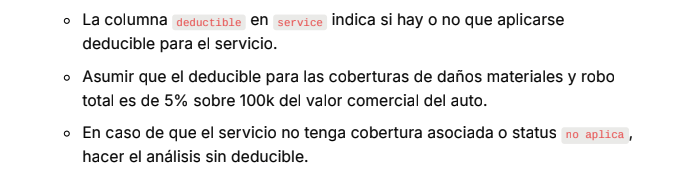

In [49]:
#Amount after deductible and Coverage
df_Service['Amount After conditions'] = np.where(
    (df_Service['deductible'] == True) & (df_Service['Cobertura'] == True),
    #deducibl is Positive here because this is an income for Crabi
    df_Service['amount']+ Deducible,
    df_Service['amount']
)
df_Service = df_Service.sort_values(by=['claim_id'],ascending=True)
df_Service

,claim_id,Status Name,amount,deductible,Cobertura,Amount After conditions
834,0188b6c3-f289-7dd6-80a1-89eaedc1df16,Reparación,-222500,True,True,-217500.0
814,0188d409-b457-712e-aee4-fb37f8cfba6d,Ajuste,222300,False,True,222300
179,0188d449-ef63-7c97-b7c3-96e863f0c579,Indemnización,200000,False,True,200000
310,0188d449-ef63-7c97-b7c3-96e863f0c579,Orden Tradicional,5000,False,True,5000
185,0188d449-ef63-7c97-b7c3-96e863f0c579,Investigación,2000,False,False,2000
...,...,...,...,...,...,...
135,018b89e8-de44-7eab-88b6-83f961605957,Reparación,-9898900,False,True,-9898900
126,018b89e8-de44-7eab-88b6-83f961605957,Reparación,-7868700,False,True,-7868700
60,018b89e8-de44-7eab-88b6-83f961605957,Reparación,-555500,False,True,-555500
243,018b9116-aebe-771c-9bc4-1128d50c5fff,Reparación,-500000,True,True,-495000.0


# Calculando la serveridad 
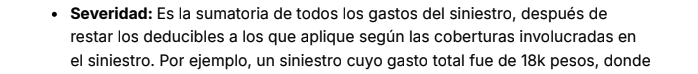

In [50]:
#Calculating Severity by Grouping Claim ID
df_severity = (
    df_Service
        .groupby("claim_id", as_index=False)["Amount After conditions"]
        .sum()
        .rename(columns={"Amount After conditions": "Severidad"})
)

df_severity

,claim_id,Severidad
0,0188b6c3-f289-7dd6-80a1-89eaedc1df16,-217500.0
1,0188d409-b457-712e-aee4-fb37f8cfba6d,222300
2,0188d449-ef63-7c97-b7c3-96e863f0c579,3027255
3,0188da6f-35ff-7a59-bbcd-76c51e540fd5,1212
4,0188dd0d-2a8c-71d8-b9a5-00a4bcc19b01,1003
...,...,...
188,018b8321-75d5-7ac3-8e0c-fa87906edc5b,-1000000
189,018b8869-1912-749d-b48f-86b2c6d951b1,-595000.0
190,018b89e8-de44-7eab-88b6-83f961605957,-685289600
191,018b9116-aebe-771c-9bc4-1128d50c5fff,-495000.0


In [51]:
df_severity["Severidad"] = pd.to_numeric(
    df_severity["Severidad"],
    errors="coerce"
)
df_severity['Severidad'].describe()

count    1.930000e+02
mean    -2.395552e+07
std      1.378168e+08
min     -1.324775e+09
25%     -1.050500e+06
50%     -2.131230e+05
75%     -1.450600e+04
max      8.989898e+06
Name: Severidad, dtype: float64

# Cleaning Claim Table

In [52]:
#Eliminando columnas
df_Claim = df_Claim.drop(columns=
                         ['address_id',
                          'original_claim_id',
                          'liability_status_id',
                          'cancelled_reason_status_id',
                          'seq',
                          'policy_id',
                          'created_by',
                          'declaration_cabin',
                          'reporting_name',
                          'third_car_description',
                          'conclusion',
                          'reporting_phone',
                          'scheduled_at',
                          'updated_at',
                          'amis_reported_at',
                          'declaration',
                          ])
df_Claim

,id,type_status_id,status_cause_type_id,number,policy_number,occurred_at,created_at,policy_person_id
0,018a111c-7788-76de-af1a-555ac43faa81,<NA>,<NA>,CRA-2023000486,AE-1002372,<NA>,2023-08-20 04:03:12+00,088fbd48-cc1c-474a-b023-a352edea3f20
1,0189b6ae-3c37-73ff-bd62-b6d45b886fee,a31a3903-7819-4d33-8a40-ad06df4e5d4b,5eec97a7-a9bb-45c8-942c-1d35454b4219,CRA-2023000382,AE-1002335,2023-08-02 04:00:00+00,2023-08-02 14:36:59+00,69beb367-a254-4756-864d-ff137c754fa8
2,0189c2d1-2a49-73db-a3c4-2399832a2942,<NA>,<NA>,CRA-2023000400,KV-1002359,<NA>,2023-08-04 23:10:35+00,0f532d2f-b838-44ad-ae0a-2563ba844db2
3,0189dc1c-1c9e-755e-8674-7d30a16b8423,a31a3903-7819-4d33-8a40-ad06df4e5d4b,<NA>,CRA-2023000433,AE-1002236,2023-08-08 03:00:00+00,2023-08-09 21:02:57+00,19661dc2-570e-4ddd-89ac-8e08243b0d74
4,0188e82c-9b05-7065-abd8-581151eb36ff,a31a3903-7819-4d33-8a40-ad06df4e5d4b,2755aed2-f65e-4f25-9de5-26b777b0b8df,CRA-2023000104,AE-1002224,2023-06-23 03:14:00+00,2023-06-23 12:13:37+00,74eed741-06ea-40c2-a153-f763aded6e9e
...,...,...,...,...,...,...,...,...
564,018a76c9-f3f8-7c15-8237-90451fcd1ceb,<NA>,<NA>,CRA-2023000527,IT-1002412,<NA>,2023-09-08 21:54:21+00,3300b4a6-8247-4470-872f-4505b7cf9be2
565,0189b747-a4a6-71e2-b816-a100688d863b,<NA>,<NA>,CRA-2023000385,KV-1002354,<NA>,2023-08-02 17:24:33+00,0f532d2f-b838-44ad-ae0a-2563ba844db2
566,018b68cc-94e8-72d4-938d-ef36410855cb,5483b077-eed8-4cbf-8b34-8a32a39490d8,<NA>,CRA-2023001082,AE-1002498,2023-10-25 05:00:00+00,2023-10-25 21:45:19+00,a74334ef-643f-419b-9667-9582ffb6a01e
567,018a9a1e-0057-7d77-a2b1-36bbeedeb1b3,a31a3903-7819-4d33-8a40-ad06df4e5d4b,<NA>,CRA-2023000536,KV-1002432,2023-09-15 06:00:00+00,2023-09-15 18:32:52+00,23e1bdd0-1901-43f2-a0c4-6f3373831bbb


In [53]:
#Merge Claim to severity table
df_Claim = df_Claim.merge(df_severity,left_on='id',right_on='claim_id',how='left')
df_Claim = df_Claim.drop(columns=['id','claim_id'])
df_Claim = df_Claim.merge(df_Status,left_on='type_status_id',right_on='type_status_id',how='left')
df_Claim = df_Claim.drop(columns = ['type_status_id','status_cause_type_id','policy_person_id','occurred_at'])
df_Claim['Severidad'] = df_Claim['Severidad'].fillna(0)

In [54]:
df_Claim

,number,policy_number,created_at,Severidad,Status Name,Status Type
0,CRA-2023000486,AE-1002372,2023-08-20 04:03:12+00,0.0,<NA>,<NA>
1,CRA-2023000382,AE-1002335,2023-08-02 14:36:59+00,-210000.0,Colisión,ClaimType
2,CRA-2023000400,KV-1002359,2023-08-04 23:10:35+00,0.0,<NA>,<NA>
3,CRA-2023000433,AE-1002236,2023-08-09 21:02:57+00,-91986.0,Colisión,ClaimType
4,CRA-2023000104,AE-1002224,2023-06-23 12:13:37+00,80500.0,Colisión,ClaimType
...,...,...,...,...,...,...
564,CRA-2023000527,IT-1002412,2023-09-08 21:54:21+00,0.0,<NA>,<NA>
565,CRA-2023000385,KV-1002354,2023-08-02 17:24:33+00,0.0,<NA>,<NA>
566,CRA-2023001082,AE-1002498,2023-10-25 21:45:19+00,0.0,Asistencia,ClaimType
567,CRA-2023000536,KV-1002432,2023-09-15 18:32:52+00,0.0,Colisión,ClaimType


# Findings 

* Existen 568 Casos Abiertos 

In [55]:
df_Claim['number'].nunique

<bound method IndexOpsMixin.nunique of 0      CRA-2023000486
1      CRA-2023000382
2      CRA-2023000400
3      CRA-2023000433
4      CRA-2023000104
            ...      
564    CRA-2023000527
565    CRA-2023000385
566    CRA-2023001082
567    CRA-2023000536
568    CRA-2023000374
Name: number, Length: 569, dtype: string>

* De los 568 Casos Solo 191 Casos involucraron algun tipo de servicio
### Solo 33% de los Claims involucraron Servicios


In [56]:
df_Claim[df_Claim['Severidad'] !=0].shape[0]

191

* El Gasto Mayor pagado por crabi fue: -1'324,774,600 $
* El Ingreso Mayor recibido fue: 8,989,898.0 $
* El valor Medio de Severidad: -8,125,509.17 $

In [57]:
col = df_Claim["Severidad"]

maximo  = col.max()
minimo  = col.min()
media   = col.mean()
mediana = col.median()

maximo, minimo, media, mediana

(8989898.0, -1324774600.0, -8125509.170474517, 0.0)

# Identificacion de Outliers

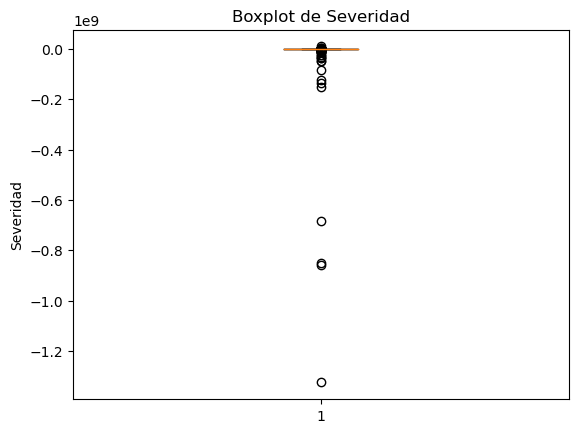

In [58]:
plt.boxplot(df_Claim["Severidad"].dropna())
plt.title("Boxplot de Severidad")
plt.ylabel("Severidad")
plt.show()

*Calculando Percentiles

In [59]:
Q1 = df_Claim["Severidad"].quantile(0.25)
Q3 = df_Claim["Severidad"].quantile(0.75)
IQR = Q3 - Q1

Q1, Q3, IQR

(-16000.0, 0.0, 16000.0)

* Definiendo Limite mayor y limite superior

In [60]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_bound, upper_bound

(-40000.0, 24000.0)

* Calculo de Outliers

In [61]:
outliers = df_Claim[
    (df_Claim["Severidad"] < lower_bound) |
    (df_Claim["Severidad"] > upper_bound)
]

outliers

,number,policy_number,created_at,Severidad,Status Name,Status Type
1,CRA-2023000382,AE-1002335,2023-08-02 14:36:59+00,-210000.0,Colisión,ClaimType
3,CRA-2023000433,AE-1002236,2023-08-09 21:02:57+00,-91986.0,Colisión,ClaimType
4,CRA-2023000104,AE-1002224,2023-06-23 12:13:37+00,80500.0,Colisión,ClaimType
9,CRA-2023000453,AE-1001765,2023-08-11 23:21:42+00,-1850169.0,Colisión,ClaimType
12,CRA-2023000497,AE-1002372,2023-08-24 16:50:14+00,-1595098.0,Colisión,ClaimType
...,...,...,...,...,...,...
557,CRA-2023000496,IT-1002366,2023-08-24 15:50:09+00,-825500.0,Colisión,ClaimType
559,CRA-2023000420,AE-1002335,2023-08-08 17:22:38+00,-8012200.0,Colisión,ClaimType
561,CRA-2023000483,WO-1002365,2023-08-18 16:06:43+00,-1200080.0,Colisión,ClaimType
563,CRA-2023000516,AE-1002398,2023-08-30 17:25:50+00,-200000.0,Colisión,ClaimType


In [62]:
df_sin_outliers = df_Claim[
    (df_Claim["Severidad"] >= lower_bound) &
    (df_Claim["Severidad"] <= upper_bound)
]
df_sin_outliers

,number,policy_number,created_at,Severidad,Status Name,Status Type
0,CRA-2023000486,AE-1002372,2023-08-20 04:03:12+00,0.0,<NA>,<NA>
2,CRA-2023000400,KV-1002359,2023-08-04 23:10:35+00,0.0,<NA>,<NA>
5,CRA-2023000410,AE-1002334,2023-08-05 04:48:26+00,0.0,Colisión,ClaimType
6,CRA-2023000421,AE-1002335,2023-08-08 17:45:07+00,0.0,Asistencia,ClaimType
7,CRA-2023000562,KV-1002040,2023-09-25 23:50:39+00,0.0,<NA>,<NA>
...,...,...,...,...,...,...
562,CRA-2023000430,CH-1002349,2023-08-09 12:28:55+00,-4738.0,Colisión,ClaimType
564,CRA-2023000527,IT-1002412,2023-09-08 21:54:21+00,0.0,<NA>,<NA>
565,CRA-2023000385,KV-1002354,2023-08-02 17:24:33+00,0.0,<NA>,<NA>
566,CRA-2023001082,AE-1002498,2023-10-25 21:45:19+00,0.0,Asistencia,ClaimType


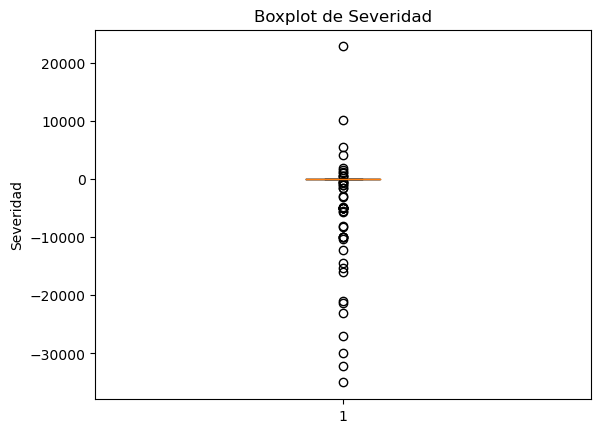

In [63]:
plt.boxplot(df_sin_outliers["Severidad"].dropna())
plt.title("Boxplot de Severidad")
plt.ylabel("Severidad")
plt.show()

In [64]:
df_sin_outliers.describe()

,Severidad
count,428.000000
mean,-778.056075
std,4201.033112
min,-35000.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,22832.000000


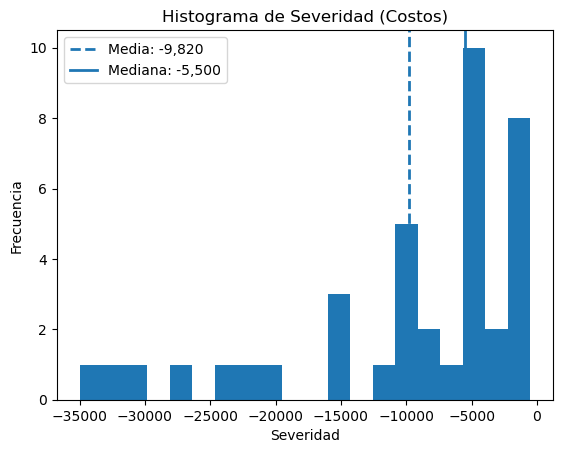

In [65]:
data = df_sin_outliers.loc[df_sin_outliers["Severidad"] < 0, "Severidad"]

mean = data.mean()
median = data.median()

plt.hist(data, bins=20)

plt.axvline(mean, linestyle="--", linewidth=2, label=f"Media: {mean:,.0f}")
plt.axvline(median, linestyle="-", linewidth=2, label=f"Mediana: {median:,.0f}")

plt.title("Histograma de Severidad (Costos)")
plt.xlabel("Severidad")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

# Calculando la siniestralidad Mensual

In [66]:
#Data frame claim, grouped by Ticket Created At
df_Claim["created_at"] = pd.to_datetime(df_Claim["created_at"])
df_Claim["month"] = df_Claim["created_at"].dt.to_period("M")
severidad_mensual = (
    df_Claim
        .groupby("month", as_index=False)["Severidad"]
        .sum()
)
severidad_mensual["prima_mensual"] = PrimasDevengadas
severidad_mensual["siniestralidad"] = (
    (severidad_mensual["Severidad"].abs())
    / severidad_mensual["prima_mensual"]
)
severidad_mensual["siniestralidad %"] = (
    severidad_mensual["siniestralidad"] * 100
)
severidad_mensual

/var/folders/fk/cvrcy451067_965x_wm3fkwc0000gn/T/ipykernel_88752/1077454126.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_Claim["month"] = df_Claim["created_at"].dt.to_period("M")


,month,Severidad,prima_mensual,siniestralidad,siniestralidad %
0,2023-06,-3.429902e+06,200000,17.149510,1.714951e+03
1,2023-07,-1.017002e+08,200000,508.501245,5.085012e+04
2,2023-08,-2.505731e+08,200000,1252.865410,1.252865e+05
3,2023-09,-2.754885e+08,200000,1377.442425,1.377442e+05
4,2023-10,-3.304612e+09,200000,16523.061000,1.652306e+06
5,2023-11,-6.876108e+08,200000,3438.054000,3.438054e+05


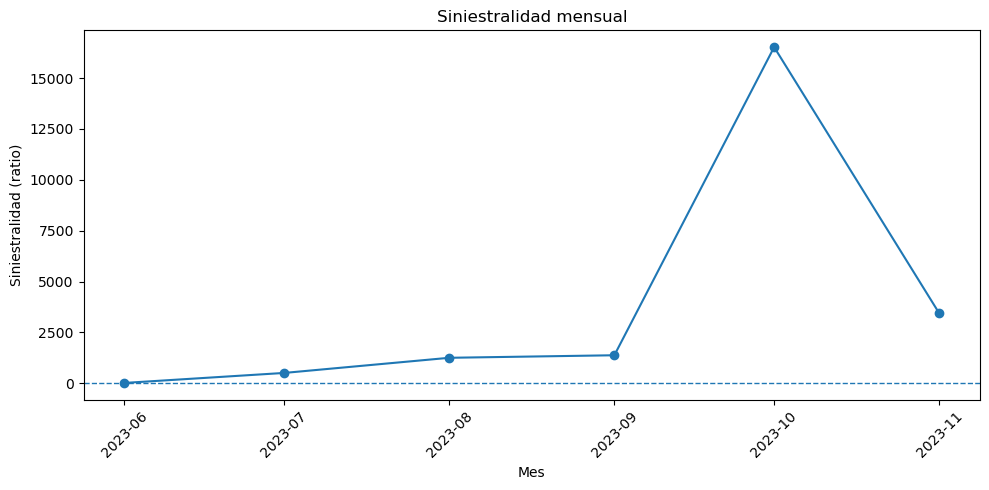

In [67]:

plot_df = severidad_mensual.copy()
plot_df["month"] = plot_df["month"].astype(str)             
plot_df["month"] = pd.to_datetime(plot_df["month"])          
plot_df = plot_df.sort_values("month")

plt.figure(figsize=(10, 5))
plt.plot(plot_df["month"], plot_df["siniestralidad"], marker="o")


plt.axhline(1, linestyle="--", linewidth=1)

plt.title("Siniestralidad mensual")
plt.xlabel("Mes")
plt.ylabel("Siniestralidad (ratio)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ¿Cuál es la cobertura con mayor y menor cantidad de siniestros?

In [68]:
# Definiendo Nuevos Data Frames 
df_Service_claim = ServiceTable
#Merging Service table with Status
df_Service_claim = df_Service_claim.merge(df_Status,left_on='coverage_id',right_on='type_status_id',how='left')
#Merging new Service with People
df_Service_claim = df_Service_claim.merge(df_people,left_on='people_id',right_on='id',how='left')

In [69]:
#Cleaning Columns 
cols = ['claim_id','Status Type','Status Name']
df_Service_claim= df_Service_claim[cols]
#Creating new Data frame for Clame table called: claim coverage 
df_Claim_coverage = claimTable
#Merging new table with Claim 
df_Claim_coverage = df_Claim_coverage.merge(df_Service_claim,left_on='id',right_on='claim_id',how='left')
cols = ['number','policy_number','Status Type','Status Name']
df_Claim_coverage = df_Claim_coverage[cols]
df_Claim_coverage.convert_dtypes()
df_Claim_coverage

,number,policy_number,Status Type,Status Name
0,CRA-2023000486,AE-1002372,<NA>,<NA>
1,CRA-2023000382,AE-1002335,<NA>,<NA>
2,CRA-2023000382,AE-1002335,CoverageType,DM
3,CRA-2023000382,AE-1002335,CoverageType,DM
4,CRA-2023000382,AE-1002335,<NA>,<NA>
...,...,...,...,...
1062,CRA-2023001082,AE-1002498,<NA>,<NA>
1063,CRA-2023000536,KV-1002432,CoverageType,No Aplica
1064,CRA-2023000374,CH-1002349,CoverageType,GM
1065,CRA-2023000374,CH-1002349,CoverageType,DM


In [70]:
#Filtrando by CoverageType
df_Claim_coverage = df_Claim_coverage[df_Claim_coverage['Status Type'] == 'CoverageType']
df_Claim_coverage

,number,policy_number,Status Type,Status Name
2,CRA-2023000382,AE-1002335,CoverageType,DM
3,CRA-2023000382,AE-1002335,CoverageType,DM
7,CRA-2023000382,AE-1002335,CoverageType,RCB
10,CRA-2023000104,AE-1002224,CoverageType,GM
12,CRA-2023000104,AE-1002224,CoverageType,RCB
...,...,...,...,...
1054,CRA-2023000430,CH-1002349,CoverageType,RCP
1057,CRA-2023000430,CH-1002349,CoverageType,DM
1063,CRA-2023000536,KV-1002432,CoverageType,No Aplica
1064,CRA-2023000374,CH-1002349,CoverageType,GM


In [71]:
#Grouping by Status Name 
coverage_counts = (
    df_Claim_coverage
        .groupby('Status Name')
        .size()
        .reset_index(name='num_claims')
        .sort_values('num_claims', ascending=False)
)

coverage_counts

,Status Name,num_claims
2,DM,220
4,No Aplica,73
3,GM,49
5,RCB,40
0,AL,20
1,AV,19
6,RCP,18
7,RT,8


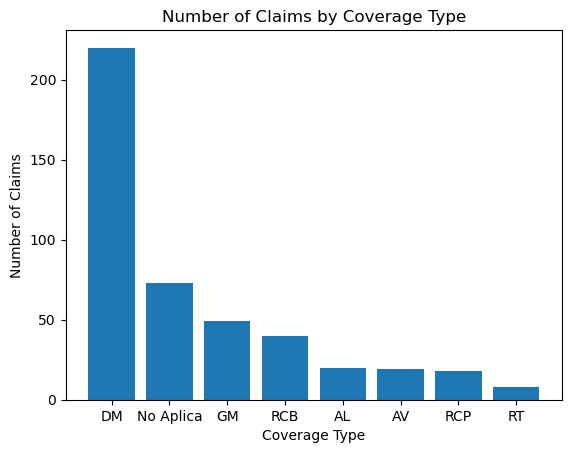

In [72]:
#Plotting  Number of claims
plt.figure()
plt.bar(
    coverage_counts['Status Name'],
    coverage_counts['num_claims']
)
plt.xlabel('Coverage Type')
plt.ylabel('Number of Claims')
plt.title('Number of Claims by Coverage Type')
plt.show()

* La cobertura con mas incidencias es Danos Materiales con 220 incidencias 
* La cobertura con menos incidencias es Robo Total con 8 claims 

# ¿Cuál es el partner con mayor y menor siniestralidad? ¿cuál es su severidad promedio?

In [73]:
#Separating Policy_number into Partner
df_Claim['partner'] = df_Claim['policy_number'].str.split('-').str[0]
df_Claim = df_Claim[df_Claim['Severidad'] != 0 ]
cols =['partner','Severidad']
df_Claim = df_Claim[cols]
df_Claim

,partner,Severidad
1,AE,-210000.0
3,AE,-91986.0
4,AE,80500.0
9,AE,-1850169.0
12,AE,-1595098.0
...,...,...
559,AE,-8012200.0
561,WO,-1200080.0
562,CH,-4738.0
563,AE,-200000.0


In [74]:
#Grouping into Partners
Partner_counts = (
    df_Claim
        .groupby('partner')['Severidad']
        .sum()
        .reset_index(name='Severity')
        .sort_values('Severity', ascending=True)
)

Partner_counts

,partner,Severity
0,AE,-2.547945e+09
3,IT,-1.868810e+09
4,KV,-1.174661e+08
5,SE,-4.058175e+07
1,CH,-2.718060e+07
2,DA,-2.023207e+07
6,WO,-1.200080e+06


In [75]:
#Average
Partner_Average = (
    df_Claim
        .groupby('partner')['Severidad']
        .mean()
        .reset_index(name='Severity')
        .sort_values('Severity', ascending=True)
)

Partner_Average

,partner,Severity
3,IT,-1.168006e+08
0,AE,-2.739725e+07
5,SE,-1.352725e+07
2,DA,-2.529008e+06
4,KV,-2.447211e+06
1,CH,-1.235482e+06
6,WO,-1.200080e+06


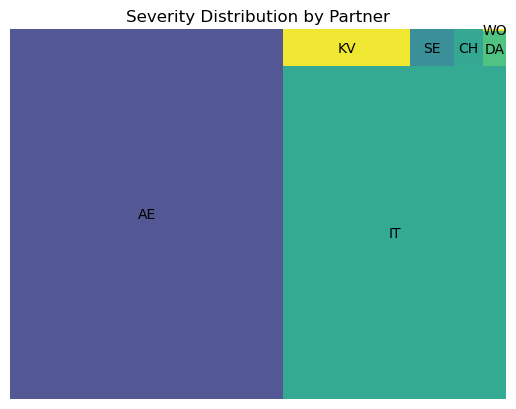

In [76]:
#Plotting  Number of claims
plt.figure()
squarify.plot(
    sizes=Partner_counts['Severity'],
    label=Partner_counts['partner'],
    alpha=0.90
)

plt.axis('off')
plt.title('Severity Distribution by Partner')
plt.show()

* El partner con la mayor severidad es AE, seguido IT y port ultimo KV

# Utilizando los datos de la tabla people , ¿dentro de qué rango etario se encuentra la mayor y menor cantidad de usuarios siniestrados? ¿cuál es su severidad promedio?

In [77]:
#Defining new data Frames
df_Claim_Age = claimTable
df_people_Age = peopleTable
df_service_Age = ServiceTable
#Cleaning Cols 
cols = ['id','number']
df_Claim_Age = df_Claim_Age[cols]
#Merging with Service Table
df_Claim_Age = df_Claim_Age.merge(df_people_Age,left_on='id',right_on='claim_id',how='inner')
df_Claim_Age
#Cleaning cols 
cols = ['number','id_y','type_status_id','first_name','birthdate']
df_Claim_Age = df_Claim_Age[cols]
df_Claim_Age
#Merging with status, Mi hipotesis es que los Status Name NA son los Asegurados de Crabi 
df_Claim_Age = df_Claim_Age.merge(df_Status,left_on='type_status_id',right_on='type_status_id',how='left')
df_Claim_Age['Status Name']= df_Claim_Age['Status Name'].fillna('Asegurado De Crabi')
df_Claim_Age
#Merging with Service
df_Claim_Age = df_Claim_Age.merge(df_service_Age,left_on='id_y',right_on='people_id',how='inner')
df_Claim_Age
#Cleaning table
cols = ['number_x','first_name','birthdate','Status Name','Status Type','amount','deductible']
df_Claim_Age = df_Claim_Age[cols]
df_Claim_Age


,number_x,first_name,birthdate,Status Name,Status Type,amount,deductible
0,CRA-2023000382,Angel,2007-07-04,Asegurado De Crabi,PeopleType,-5000,False
1,CRA-2023000382,Angel,2007-07-04,Asegurado De Crabi,PeopleType,-5000,False
2,CRA-2023000382,Angel,2007-07-04,Asegurado De Crabi,PeopleType,0,False
3,CRA-2023000382,Juan,NaT,Tercero Conductor,PeopleType,0,False
4,CRA-2023000382,Juan,NaT,Tercero Conductor,PeopleType,0,False
...,...,...,...,...,...,...,...
833,CRA-2023000516,Sandra,1972-09-09,Asegurado De Crabi,PeopleType,0,False
834,CRA-2023000536,Dangelo,1972-01-20,Asegurado De Crabi,PeopleType,0,False
835,CRA-2023000374,Carlos,1980-01-01,Asegurado De Crabi,PeopleType,-232200,False
836,CRA-2023000374,Carlos,1980-01-01,Asegurado De Crabi,PeopleType,-3400,True


In [78]:
#Calculando edad
df_Claim_Age['birthdate'] = pd.to_datetime(df_Claim_Age['birthdate'])
df_Claim_Age['edad'] = np.where(
df_Claim_Age['birthdate'].notna(),
#Si no es NA calcula la diferencia de hoy entre la fecha de naciemiento
hoy.year -df_Claim_Age['birthdate'].dt.year,
#Si es 0 escoge un numero al azar del 0 al 90
random.randint(0,90)
)
df_Claim_Age

,number_x,first_name,birthdate,Status Name,Status Type,amount,deductible,edad
0,CRA-2023000382,Angel,2007-07-04,Asegurado De Crabi,PeopleType,-5000,False,19.0
1,CRA-2023000382,Angel,2007-07-04,Asegurado De Crabi,PeopleType,-5000,False,19.0
2,CRA-2023000382,Angel,2007-07-04,Asegurado De Crabi,PeopleType,0,False,19.0
3,CRA-2023000382,Juan,NaT,Tercero Conductor,PeopleType,0,False,6.0
4,CRA-2023000382,Juan,NaT,Tercero Conductor,PeopleType,0,False,6.0
...,...,...,...,...,...,...,...,...
833,CRA-2023000516,Sandra,1972-09-09,Asegurado De Crabi,PeopleType,0,False,54.0
834,CRA-2023000536,Dangelo,1972-01-20,Asegurado De Crabi,PeopleType,0,False,54.0
835,CRA-2023000374,Carlos,1980-01-01,Asegurado De Crabi,PeopleType,-232200,False,46.0
836,CRA-2023000374,Carlos,1980-01-01,Asegurado De Crabi,PeopleType,-3400,True,46.0


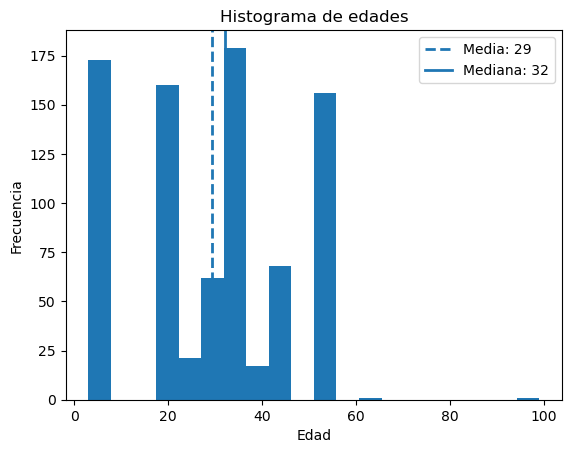

In [79]:
#Calculating Hist per 
data = df_Claim_Age['edad']

mean = data.mean()
median = data.median()

plt.hist(data, bins=20)

plt.axvline(mean, linestyle="--", linewidth=2, label=f"Media: {mean:,.0f}")
plt.axvline(median, linestyle="-", linewidth=2, label=f"Mediana: {median:,.0f}")

plt.title("Histograma de edades")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

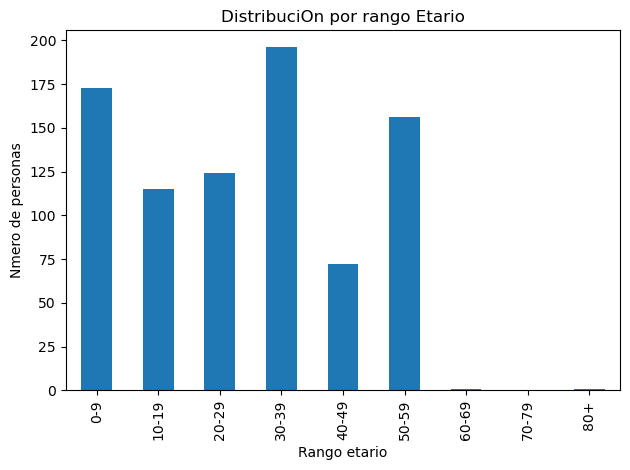

In [80]:
df_Claim_Age["edad"] = pd.to_numeric(df_Claim_Age["edad"], errors="coerce")

# Defining Bins and labels 
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 120]
labels = ["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80+"]

df_Claim_Age["rango_etario"] = pd.cut(df_Claim_Age["edad"], bins=bins, labels=labels, right=False)


order = df_Claim_Age["rango_etario"].value_counts().sort_index()

# bar graph
order.plot(kind="bar")
plt.title("DistribuciOn por rango Etario")
plt.xlabel("Rango etario")
plt.ylabel("Nmero de personas")
plt.tight_layout()
plt.show()

* El rango Etario de personas que mas incidencia tienen es el de 30 a 39, seguido del rango 50-59
* El rango Etario con menos incidencias es de 40-49 

# Research Adicional

1. Cual es usuario Crabi que ha representado un costo mayor para la compania?
2. Que porcentaje de los Servicios son para el asegurado

In [81]:
#Grouping into users 

User_Sum = (
df_Claim_Age
        .groupby('number_x')['amount']
        .sum()
        .reset_index(name='amount')
        .sort_values('amount', ascending=True)
)
#Merging with original data frame
User_Sum = User_Sum.merge(df_Claim_Age,left_on='number_x',right_on='number_x')
User_Sum = User_Sum[User_Sum['Status Name'] == 'Asegurado De Crabi']
User_Sum = User_Sum.drop_duplicates(subset=['number_x'])
User_Sum

,number_x,amount_x,first_name,birthdate,Status Name,Status Type,amount_y,deductible,edad,rango_etario
0,CRA-2023000576,-1324774600,asad,1993-08-04,Asegurado De Crabi,PeopleType,-12312300,False,33.0,30-39
4,CRA-2023000590,-857875300,alam,1983-01-13,Asegurado De Crabi,PeopleType,-5000000,False,43.0,40-49
9,CRA-2023000583,-849848700,alam,1972-01-20,Asegurado De Crabi,PeopleType,-849848700,False,54.0,50-59
10,CRA-2023001095,-685289600,asdsad,2006-10-11,Asegurado De Crabi,PeopleType,-500000,False,20.0,20-29
21,CRA-2023001048,-150050000,alam,1983-10-06,Asegurado De Crabi,PeopleType,-150000000,False,43.0,40-49
...,...,...,...,...,...,...,...,...,...,...
812,CRA-2023000090,222300,Roberto edit,1980-09-17,Asegurado De Crabi,PeopleType,222300,False,46.0,40-49
813,CRA-2023000146,987900,Javier,1972-01-20,Asegurado De Crabi,PeopleType,987900,False,54.0,50-59
814,CRA-2023000092,3027255,Homero,1990-01-02,Asegurado De Crabi,PeopleType,0,False,36.0,30-39
833,CRA-2023000575,3041800,Kyra,1972-01-20,Asegurado De Crabi,PeopleType,-100,False,54.0,50-59


* El Asegurado Crabi CRA-2023000576	 de nombre Asad es el usuario mas costoso para Crabi, con un total de 1'324,774,600
* Por otro lado tenemos a Federico usuario CRA-2023000188, Federico hizo ganar a Crabi 89,898,98

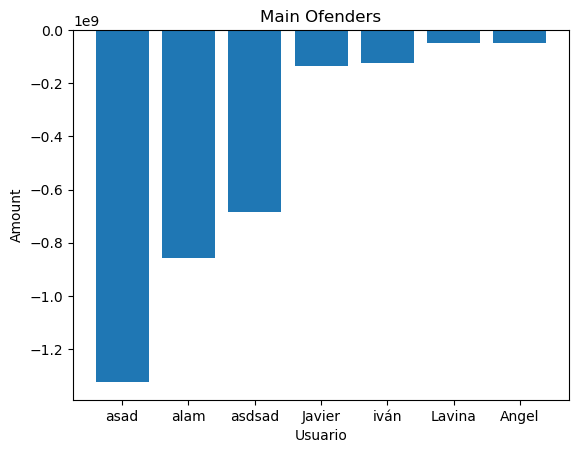

In [82]:
#Plotting data
data = User_Sum.head(10)
plt.figure()
plt.bar(
    data['first_name'],
    data['amount_x']
)
plt.xlabel('Usuario')
plt.ylabel('Amount')
plt.title('Main Ofenders')
plt.show()

In [84]:
st.write("""
# My first app
Hello *world!*
""")
 


2026-01-16 14:33:36.885 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-16 14:33:36.889 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-16 14:33:36.890 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
